In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
# Set display option to show all columns
pd.set_option('display.max_columns', None)

# 1. Data Loading

In [12]:
# Load DataFrame from the feather file
trans_df = pd.read_feather('trans_df.feather')

In [3]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 84 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   Transaction_id                            object 
 1   Last_transaction_time_elapsed_minutes     float64
 2   Hour                                      int32  
 3   Minute                                    int32  
 4   Date                                      object 
 5   Year                                      int32  
 6   Month                                     int32  
 7   Day                                       int32  
 8   Sender_account                            int64  
 9   Receiver_account                          int64  
 10  Amount                                    float64
 11  Amount_USD                                float64
 12  Payment_currency                          object 
 13  Received_currency                         object 
 14  Se

In [13]:
trans_df.columns

Index(['Transaction_id', 'Last_transaction_time_elapsed_minutes', 'Hour',
       'Minute', 'Date', 'Year', 'Month', 'Day', 'Sender_account',
       'Receiver_account', 'Amount', 'Amount_USD', 'Payment_currency',
       'Received_currency', 'Sender_bank_location', 'Receiver_bank_location',
       'Payment_type', 'Is_laundering', 'Laundering_type',
       'Different_Currency', 'sender_f_degree_in', 'sender_f_degree_out',
       'sender_f_amount_in', 'sender_f_amount_out', 'sender_f_nr_trans_in',
       'sender_f_nr_trans_out', 'sender_f_ego_nr_nodes',
       'sender_f_ego_nr_edges', 'sender_f_average_amount_in',
       'sender_f_average_amount_out', 'sender_f_ego_edge_density',
       'sender_f_egored_degree_in', 'sender_f_egored_degree_out',
       'sender_f_egored_amount_in', 'sender_f_egored_amount_out',
       'sender_f_egored_nr_trans_in', 'sender_f_egored_nr_trans_out',
       'sender_f_egored_nr_nodes', 'sender_f_egored_nr_edges',
       'sender_f_egored_average_amount_in',
      

# 2. Preparing Model Training and Testing Set

## 2.1 Select Needed Columns

In [14]:
trans_df = trans_df[['Transaction_id','Sender_account', 'Receiver_account',
                     'Last_transaction_time_elapsed_minutes', 'Amount_USD', 'Sender_bank_location', 
                    'Receiver_bank_location', 'Payment_type', 'Different_Currency', 'Is_laundering',
                    'Laundering_type', 'sender_f_degree_in', 'sender_f_degree_out',
                    'sender_f_amount_in', 'sender_f_amount_out', 'sender_f_nr_trans_in',
                    'sender_f_nr_trans_out','sender_f_average_amount_in',
                    'sender_f_average_amount_out', 'sender_f_ego_edge_density',
                    'sender_f_egored_degree_in', 'sender_f_egored_degree_out',
                    'sender_f_egored_amount_in', 'sender_f_egored_amount_out',
                    'sender_f_egored_nr_trans_in', 'sender_f_egored_nr_trans_out',
                    'sender_f_egored_average_amount_in',
                    'sender_f_egored_average_amount_out', 'sender_f_egored_edge_density',
                    'sender_f_egored_degree_in_rel', 'sender_f_egored_degree_out_rel',
                    'sender_f_egored_amount_in_rel', 'sender_f_egored_amount_out_rel',
                    'sender_f_egored_average_amount_in_rel',
                    'sender_f_egored_average_amount_out_rel',
                    'sender_max_cycle_length', 'sender_cycle_total_amount_USD',
                    'receiver_f_degree_in', 'receiver_f_degree_out', 'receiver_f_amount_in',
                    'receiver_f_amount_out', 'receiver_f_nr_trans_in',
                    'receiver_f_nr_trans_out','receiver_f_average_amount_in',
                    'receiver_f_average_amount_out', 'receiver_f_ego_edge_density',
                    'receiver_f_egored_degree_in', 'receiver_f_egored_degree_out',
                    'receiver_f_egored_amount_in', 'receiver_f_egored_amount_out',
                    'receiver_f_egored_nr_trans_in', 'receiver_f_egored_nr_trans_out',
                    'receiver_f_egored_average_amount_in',
                    'receiver_f_egored_average_amount_out',
                    'receiver_f_egored_edge_density', 'receiver_f_egored_degree_in_rel',
                    'receiver_f_egored_degree_out_rel', 'receiver_f_egored_amount_in_rel',
                    'receiver_f_egored_amount_out_rel',
                    'receiver_f_egored_average_amount_in_rel',
                    'receiver_f_egored_average_amount_out_rel',
                    'receiver_max_cycle_length', 'receiver_cycle_total_amount_USD']]


## 2.2 Applying Ordinal Encoding to columns 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type'

### 2.2.1 Applying Risk Score to columns 'Sender_bank_location' and 'Receiver_bank_location'

- Refer to ranking in this page -> https://index.baselgovernance.org/ranking, https://aml-cft.net/high-risk-countries/ (India)

- Some Countries have higher money laundering risk compared to others, ordinal ranking can be applied to them

- Use round of value of risk score, for example United Kingdom 3.66 -> 4.0

In [5]:
bank_location = pd.concat([trans_df['Sender_bank_location'], trans_df['Receiver_bank_location']])
bank_location.unique()

array(['UK', 'Japan', 'Albania', 'Morocco', 'Nigeria', 'Mexico', 'Spain',
       'France', 'Switzerland', 'USA', 'Netherlands', 'Germany',
       'Pakistan', 'Turkey', 'UAE', 'India', 'Italy', 'Austria'],
      dtype=object)

In [15]:
# store country and risk score as dictionary
location_risk_dict = {
    'UK':4,
    'Japan':5,
    'Albania':5,
    'Morocco':5,
    'Nigeria':7,
    'Mexico':5,
    'Spain':4,
    'France':4,
    'Switzerland':4,
    'USA':4,
    'Netherlands':4,
    'Germany':4,
    'Pakistan':5,
    'Turkey':6,
    'UAE':6,
    'India':6,
    'Italy':5,
    'Austria':4
}

In [16]:
def apply_location_risk(location, location_risk_dict):
    return location_risk_dict[location]


In [17]:
trans_df['Sender_bank_location_risk'] = np.vectorize(apply_location_risk)(trans_df['Sender_bank_location'], location_risk_dict )

In [18]:
trans_df['Receiver_bank_location_risk'] = np.vectorize(apply_location_risk)(trans_df['Receiver_bank_location'], location_risk_dict )

In [19]:
trans_df.head()

,Transaction_id,Sender_account,Receiver_account,Last_transaction_time_elapsed_minutes,Amount_USD,Sender_bank_location,Receiver_bank_location,Payment_type,Different_Currency,Is_laundering,Laundering_type,sender_f_degree_in,sender_f_degree_out,sender_f_amount_in,sender_f_amount_out,sender_f_nr_trans_in,sender_f_nr_trans_out,sender_f_average_amount_in,sender_f_average_amount_out,sender_f_ego_edge_density,sender_f_egored_degree_in,sender_f_egored_degree_out,sender_f_egored_amount_in,sender_f_egored_amount_out,sender_f_egored_nr_trans_in,sender_f_egored_nr_trans_out,sender_f_egored_average_amount_in,sender_f_egored_average_amount_out,sender_f_egored_edge_density,sender_f_egored_degree_in_rel,sender_f_egored_degree_out_rel,sender_f_egored_amount_in_rel,sender_f_egored_amount_out_rel,sender_f_egored_average_amount_in_rel,sender_f_egored_average_amount_out_rel,sender_max_cycle_length,sender_cycle_total_amount_USD,receiver_f_degree_in,receiver_f_degree_out,receiver_f_amount_in,receiver_f_amount_out,receiver_f_nr_trans_in,receiver_f_nr_trans_out,receiver_f_average_amount_in,receiver_f_average_amount_out,receiver_f_ego_edge_density,receiver_f_egored_degree_in,receiver_f_egored_degree_out,receiver_f_egored_amount_in,receiver_f_egored_amount_out,receiver_f_egored_nr_trans_in,receiver_f_egored_nr_trans_out,receiver_f_egored_average_amount_in,receiver_f_egored_average_amount_out,receiver_f_egored_edge_density,receiver_f_egored_degree_in_rel,receiver_f_egored_degree_out_rel,receiver_f_egored_amount_in_rel,receiver_f_egored_amount_out_rel,receiver_f_egored_average_amount_in_rel,receiver_f_egored_average_amount_out_rel,receiver_max_cycle_length,receiver_cycle_total_amount_USD,Sender_bank_location_risk,Receiver_bank_location_risk
0,T8572083,9018,2388293593,0.000000,4193.964216,UK,Germany,Cross-border,Yes,0,Normal_Foward,1,1,4193.964216,4193.964216,1,1,4193.964216,4193.964216,0.666667,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,1,0,4.193964e+03,0.000000e+00,1,0,4193.964216,0.000000,0.500000,0,0,0.00000,0.000000e+00,0,0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,4,4
1,T3210515,28511,3072405466,0.000000,8050.711500,UK,UK,Debit card,No,0,Normal_Plus_Mutual,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.89732,1.6,0.222222,0.117647,0.193525,0.264304,1.894509,13.555017,2,509996.402604,4,4
2,T4191568,28511,3072405466,44643.383333,4900.240800,UK,UK,Debit card,No,0,Normal_Plus_Mutual,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.89732,1.6,0.222222,0.117647,0.193525,0.264304,1.894509,13.555017,2,509996.402604,4,4
3,T5018227,28511,3072405466,40160.350000,5193.294912,UK,UK,Debit card,No,0,Normal_Plus_Mutual,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.89732,1.6,0.222222,0.117647,0.193525,0.264304,1.894509,13.555017,2,509996.402604,4,4
4,T5938109,28511,3072405466,44566.183333,9031.682088,UK,UK,Debit card,No,0,Normal_Plus_Mutual,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.89732

### 2.2.2 Applying Ordinal Ranking to column 'Payment_type'

- Use frequencies to determine the money laundering ranking for each payment type

In [20]:
mask = trans_df['Is_laundering'] == 1
trans_df[mask]['Payment_type'].value_counts()

Payment_type
Cross-border       2628
Cash Deposit       1405
Cash Withdrawal    1334
ACH                1159
Credit card        1136
Debit card         1124
Cheque             1087
Name: count, dtype: int64

In [22]:
payment_risk_dict = {
    'Cheque':1,
    'Debit card':2,
    'Credit card':3,
    'ACH':4,
    'Cash Withdrawal':5,
    'Cash Deposit':6,
    'Cross-border':7
}

In [23]:
def apply_payment_type_risk(payment_type, payment_risk_dict):
    return payment_risk_dict[payment_type]

In [24]:
trans_df['Payment_type_risk'] = np.vectorize(apply_payment_type_risk)(trans_df['Payment_type'], payment_risk_dict)

In [25]:
trans_df.head()

,Transaction_id,Sender_account,Receiver_account,Last_transaction_time_elapsed_minutes,Amount_USD,Sender_bank_location,Receiver_bank_location,Payment_type,Different_Currency,Is_laundering,Laundering_type,sender_f_degree_in,sender_f_degree_out,sender_f_amount_in,sender_f_amount_out,sender_f_nr_trans_in,sender_f_nr_trans_out,sender_f_average_amount_in,sender_f_average_amount_out,sender_f_ego_edge_density,sender_f_egored_degree_in,sender_f_egored_degree_out,sender_f_egored_amount_in,sender_f_egored_amount_out,sender_f_egored_nr_trans_in,sender_f_egored_nr_trans_out,sender_f_egored_average_amount_in,sender_f_egored_average_amount_out,sender_f_egored_edge_density,sender_f_egored_degree_in_rel,sender_f_egored_degree_out_rel,sender_f_egored_amount_in_rel,sender_f_egored_amount_out_rel,sender_f_egored_average_amount_in_rel,sender_f_egored_average_amount_out_rel,sender_max_cycle_length,sender_cycle_total_amount_USD,receiver_f_degree_in,receiver_f_degree_out,receiver_f_amount_in,receiver_f_amount_out,receiver_f_nr_trans_in,receiver_f_nr_trans_out,receiver_f_average_amount_in,receiver_f_average_amount_out,receiver_f_ego_edge_density,receiver_f_egored_degree_in,receiver_f_egored_degree_out,receiver_f_egored_amount_in,receiver_f_egored_amount_out,receiver_f_egored_nr_trans_in,receiver_f_egored_nr_trans_out,receiver_f_egored_average_amount_in,receiver_f_egored_average_amount_out,receiver_f_egored_edge_density,receiver_f_egored_degree_in_rel,receiver_f_egored_degree_out_rel,receiver_f_egored_amount_in_rel,receiver_f_egored_amount_out_rel,receiver_f_egored_average_amount_in_rel,receiver_f_egored_average_amount_out_rel,receiver_max_cycle_length,receiver_cycle_total_amount_USD,Sender_bank_location_risk,Receiver_bank_location_risk,Payment_type_risk
0,T8572083,9018,2388293593,0.000000,4193.964216,UK,Germany,Cross-border,Yes,0,Normal_Foward,1,1,4193.964216,4193.964216,1,1,4193.964216,4193.964216,0.666667,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,1,0,4.193964e+03,0.000000e+00,1,0,4193.964216,0.000000,0.500000,0,0,0.00000,0.000000e+00,0,0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,4,4,7
1,T3210515,28511,3072405466,0.000000,8050.711500,UK,UK,Debit card,No,0,Normal_Plus_Mutual,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.89732,1.6,0.222222,0.117647,0.193525,0.264304,1.894509,13.555017,2,509996.402604,4,4,2
2,T4191568,28511,3072405466,44643.383333,4900.240800,UK,UK,Debit card,No,0,Normal_Plus_Mutual,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.89732,1.6,0.222222,0.117647,0.193525,0.264304,1.894509,13.555017,2,509996.402604,4,4,2
3,T5018227,28511,3072405466,40160.350000,5193.294912,UK,UK,Debit card,No,0,Normal_Plus_Mutual,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.89732,1.6,0.222222,0.117647,0.193525,0.264304,1.894509,13.555017,2,509996.402604,4,4,2
4,T5938109,28511,3072405466,44566.183333,9031.682088,UK,UK,Debit card,No,0,Normal_Plus_Mutual,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7

### 2.2.3 Applying boolean values to column 'Different_Currency'

In [26]:
trans_df['Different_Currency'] = trans_df['Different_Currency'].map({'Yes':1, "No":0})

In [27]:
trans_df.head()

,Transaction_id,Sender_account,Receiver_account,Last_transaction_time_elapsed_minutes,Amount_USD,Sender_bank_location,Receiver_bank_location,Payment_type,Different_Currency,Is_laundering,Laundering_type,sender_f_degree_in,sender_f_degree_out,sender_f_amount_in,sender_f_amount_out,sender_f_nr_trans_in,sender_f_nr_trans_out,sender_f_average_amount_in,sender_f_average_amount_out,sender_f_ego_edge_density,sender_f_egored_degree_in,sender_f_egored_degree_out,sender_f_egored_amount_in,sender_f_egored_amount_out,sender_f_egored_nr_trans_in,sender_f_egored_nr_trans_out,sender_f_egored_average_amount_in,sender_f_egored_average_amount_out,sender_f_egored_edge_density,sender_f_egored_degree_in_rel,sender_f_egored_degree_out_rel,sender_f_egored_amount_in_rel,sender_f_egored_amount_out_rel,sender_f_egored_average_amount_in_rel,sender_f_egored_average_amount_out_rel,sender_max_cycle_length,sender_cycle_total_amount_USD,receiver_f_degree_in,receiver_f_degree_out,receiver_f_amount_in,receiver_f_amount_out,receiver_f_nr_trans_in,receiver_f_nr_trans_out,receiver_f_average_amount_in,receiver_f_average_amount_out,receiver_f_ego_edge_density,receiver_f_egored_degree_in,receiver_f_egored_degree_out,receiver_f_egored_amount_in,receiver_f_egored_amount_out,receiver_f_egored_nr_trans_in,receiver_f_egored_nr_trans_out,receiver_f_egored_average_amount_in,receiver_f_egored_average_amount_out,receiver_f_egored_edge_density,receiver_f_egored_degree_in_rel,receiver_f_egored_degree_out_rel,receiver_f_egored_amount_in_rel,receiver_f_egored_amount_out_rel,receiver_f_egored_average_amount_in_rel,receiver_f_egored_average_amount_out_rel,receiver_max_cycle_length,receiver_cycle_total_amount_USD,Sender_bank_location_risk,Receiver_bank_location_risk,Payment_type_risk
0,T8572083,9018,2388293593,0.000000,4193.964216,UK,Germany,Cross-border,1,0,Normal_Foward,1,1,4193.964216,4193.964216,1,1,4193.964216,4193.964216,0.666667,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,1,0,4.193964e+03,0.000000e+00,1,0,4193.964216,0.000000,0.500000,0,0,0.00000,0.000000e+00,0,0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,4,4,7
1,T3210515,28511,3072405466,0.000000,8050.711500,UK,UK,Debit card,0,0,Normal_Plus_Mutual,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.89732,1.6,0.222222,0.117647,0.193525,0.264304,1.894509,13.555017,2,509996.402604,4,4,2
2,T4191568,28511,3072405466,44643.383333,4900.240800,UK,UK,Debit card,0,0,Normal_Plus_Mutual,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.89732,1.6,0.222222,0.117647,0.193525,0.264304,1.894509,13.555017,2,509996.402604,4,4,2
3,T5018227,28511,3072405466,40160.350000,5193.294912,UK,UK,Debit card,0,0,Normal_Plus_Mutual,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.89732,1.6,0.222222,0.117647,0.193525,0.264304,1.894509,13.555017,2,509996.402604,4,4,2
4,T5938109,28511,3072405466,44566.183333,9031.682088,UK,UK,Debit card,0,0,Normal_Plus_Mutual,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669

In [28]:
trans_df.columns

Index(['Transaction_id', 'Sender_account', 'Receiver_account',
       'Last_transaction_time_elapsed_minutes', 'Amount_USD',
       'Sender_bank_location', 'Receiver_bank_location', 'Payment_type',
       'Different_Currency', 'Is_laundering', 'Laundering_type',
       'sender_f_degree_in', 'sender_f_degree_out', 'sender_f_amount_in',
       'sender_f_amount_out', 'sender_f_nr_trans_in', 'sender_f_nr_trans_out',
       'sender_f_average_amount_in', 'sender_f_average_amount_out',
       'sender_f_ego_edge_density', 'sender_f_egored_degree_in',
       'sender_f_egored_degree_out', 'sender_f_egored_amount_in',
       'sender_f_egored_amount_out', 'sender_f_egored_nr_trans_in',
       'sender_f_egored_nr_trans_out', 'sender_f_egored_average_amount_in',
       'sender_f_egored_average_amount_out', 'sender_f_egored_edge_density',
       'sender_f_egored_degree_in_rel', 'sender_f_egored_degree_out_rel',
       'sender_f_egored_amount_in_rel', 'sender_f_egored_amount_out_rel',
       'sender_f

In [30]:
# rearrange columns
trans_df = trans_df[[
    'Transaction_id', 'Sender_account', 'Receiver_account',
    'Sender_bank_location', 'Receiver_bank_location', 'Payment_type',
    'Last_transaction_time_elapsed_minutes', 'Amount_USD', 'Sender_bank_location_risk',
    'Receiver_bank_location_risk', 'Payment_type_risk',
    'Different_Currency', 'sender_f_degree_in', 'sender_f_degree_out', 'sender_f_amount_in',
    'sender_f_amount_out', 'sender_f_nr_trans_in', 'sender_f_nr_trans_out',
    'sender_f_average_amount_in', 'sender_f_average_amount_out',
    'sender_f_ego_edge_density', 'sender_f_egored_degree_in',
    'sender_f_egored_degree_out', 'sender_f_egored_amount_in',
    'sender_f_egored_amount_out', 'sender_f_egored_nr_trans_in',
    'sender_f_egored_nr_trans_out', 'sender_f_egored_average_amount_in',
    'sender_f_egored_average_amount_out', 'sender_f_egored_edge_density',
    'sender_f_egored_degree_in_rel', 'sender_f_egored_degree_out_rel',
    'sender_f_egored_amount_in_rel', 'sender_f_egored_amount_out_rel',
    'sender_f_egored_average_amount_in_rel',
    'sender_f_egored_average_amount_out_rel', 'sender_max_cycle_length',
    'sender_cycle_total_amount_USD', 'receiver_f_degree_in',
    'receiver_f_degree_out', 'receiver_f_amount_in',
    'receiver_f_amount_out', 'receiver_f_nr_trans_in',
    'receiver_f_nr_trans_out', 'receiver_f_average_amount_in',
    'receiver_f_average_amount_out', 'receiver_f_ego_edge_density',
    'receiver_f_egored_degree_in', 'receiver_f_egored_degree_out',
    'receiver_f_egored_amount_in', 'receiver_f_egored_amount_out',
    'receiver_f_egored_nr_trans_in', 'receiver_f_egored_nr_trans_out',
    'receiver_f_egored_average_amount_in',
    'receiver_f_egored_average_amount_out',
    'receiver_f_egored_edge_density', 'receiver_f_egored_degree_in_rel',
    'receiver_f_egored_degree_out_rel', 'receiver_f_egored_amount_in_rel',
    'receiver_f_egored_amount_out_rel',
    'receiver_f_egored_average_amount_in_rel',
    'receiver_f_egored_average_amount_out_rel', 'receiver_max_cycle_length',
    'receiver_cycle_total_amount_USD', 'Is_laundering', 'Laundering_type'
]]

In [31]:
trans_df.head()

,Transaction_id,Sender_account,Receiver_account,Sender_bank_location,Receiver_bank_location,Payment_type,Last_transaction_time_elapsed_minutes,Amount_USD,Sender_bank_location_risk,Receiver_bank_location_risk,Payment_type_risk,Different_Currency,sender_f_degree_in,sender_f_degree_out,sender_f_amount_in,sender_f_amount_out,sender_f_nr_trans_in,sender_f_nr_trans_out,sender_f_average_amount_in,sender_f_average_amount_out,sender_f_ego_edge_density,sender_f_egored_degree_in,sender_f_egored_degree_out,sender_f_egored_amount_in,sender_f_egored_amount_out,sender_f_egored_nr_trans_in,sender_f_egored_nr_trans_out,sender_f_egored_average_amount_in,sender_f_egored_average_amount_out,sender_f_egored_edge_density,sender_f_egored_degree_in_rel,sender_f_egored_degree_out_rel,sender_f_egored_amount_in_rel,sender_f_egored_amount_out_rel,sender_f_egored_average_amount_in_rel,sender_f_egored_average_amount_out_rel,sender_max_cycle_length,sender_cycle_total_amount_USD,receiver_f_degree_in,receiver_f_degree_out,receiver_f_amount_in,receiver_f_amount_out,receiver_f_nr_trans_in,receiver_f_nr_trans_out,receiver_f_average_amount_in,receiver_f_average_amount_out,receiver_f_ego_edge_density,receiver_f_egored_degree_in,receiver_f_egored_degree_out,receiver_f_egored_amount_in,receiver_f_egored_amount_out,receiver_f_egored_nr_trans_in,receiver_f_egored_nr_trans_out,receiver_f_egored_average_amount_in,receiver_f_egored_average_amount_out,receiver_f_egored_edge_density,receiver_f_egored_degree_in_rel,receiver_f_egored_degree_out_rel,receiver_f_egored_amount_in_rel,receiver_f_egored_amount_out_rel,receiver_f_egored_average_amount_in_rel,receiver_f_egored_average_amount_out_rel,receiver_max_cycle_length,receiver_cycle_total_amount_USD,Is_laundering,Laundering_type
0,T8572083,9018,2388293593,UK,Germany,Cross-border,0.000000,4193.964216,4,4,7,1,1,1,4193.964216,4193.964216,1,1,4193.964216,4193.964216,0.666667,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,1,0,4.193964e+03,0.000000e+00,1,0,4193.964216,0.000000,0.500000,0,0,0.00000,0.000000e+00,0,0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,Normal_Foward
1,T3210515,28511,3072405466,UK,UK,Debit card,0.000000,8050.711500,4,4,2,0,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.89732,1.6,0.222222,0.117647,0.193525,0.264304,1.894509,13.555017,2,509996.402604,0,Normal_Plus_Mutual
2,T4191568,28511,3072405466,UK,UK,Debit card,44643.383333,4900.240800,4,4,2,0,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.89732,1.6,0.222222,0.117647,0.193525,0.264304,1.894509,13.555017,2,509996.402604,0,Normal_Plus_Mutual
3,T5018227,28511,3072405466,UK,UK,Debit card,40160.350000,5193.294912,4,4,2,0,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.89732,1.6,0.222222,0.117647,0.193525,0.264304,1.894509,13.555017,2,509996.402604,0,Normal_Plus_Mutual
4,T5938109,28511,3072405466,UK,UK,Debit card,44566.183333,9031.682088,4,4,2,0,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.000000,1,1,90950.339376,51803.695476,1,7,90950.339376,7400.527925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,142754.034852,18,34,2.814767e+06,5.140855e+06,186,359,15133.153766,14319.930502,1.061224,4,4,544728.04074,1.358748e+06,19,7,28669.896881,194106.

# 3. Prepare Training 70% and Testing 30% Dataframe 

In [32]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = trans_df.drop(['Is_laundering', 'Laundering_type'], axis=1)  # Features
y = trans_df[['Is_laundering', 'Laundering_type']]  # Target variables

# Perform train-test split with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
del X, y

# Verify the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (6653396, 64)
X_test shape: (2851456, 64)
y_train shape: (6653396, 2)
y_test shape: (2851456, 2)


In [33]:
import pandas as pd

del trans_df

# Concatenate X_train and y_train to form the training dataframe
train_df = pd.concat([X_train, y_train], axis=1)
del X_train, y_train

# Concatenate X_test and y_test to form the testing dataframe
test_df = pd.concat([X_test, y_test], axis=1)
del X_test, y_test

# Verify the shapes of the resulting dataframes
print("Training dataframe shape:", train_df.shape)
print("Testing dataframe shape:", test_df.shape)


Training dataframe shape: (6653396, 66)
Testing dataframe shape: (2851456, 66)


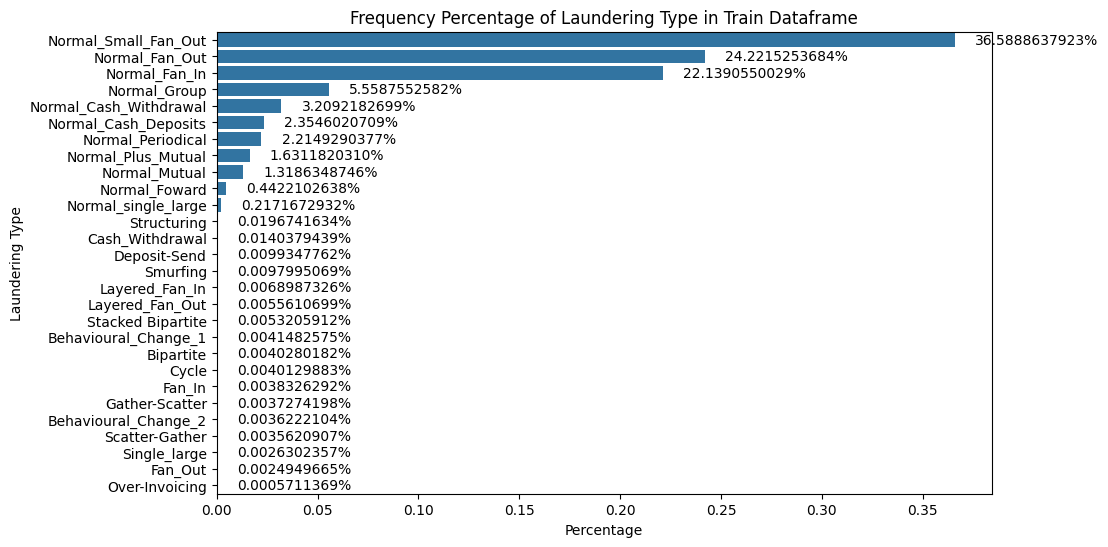

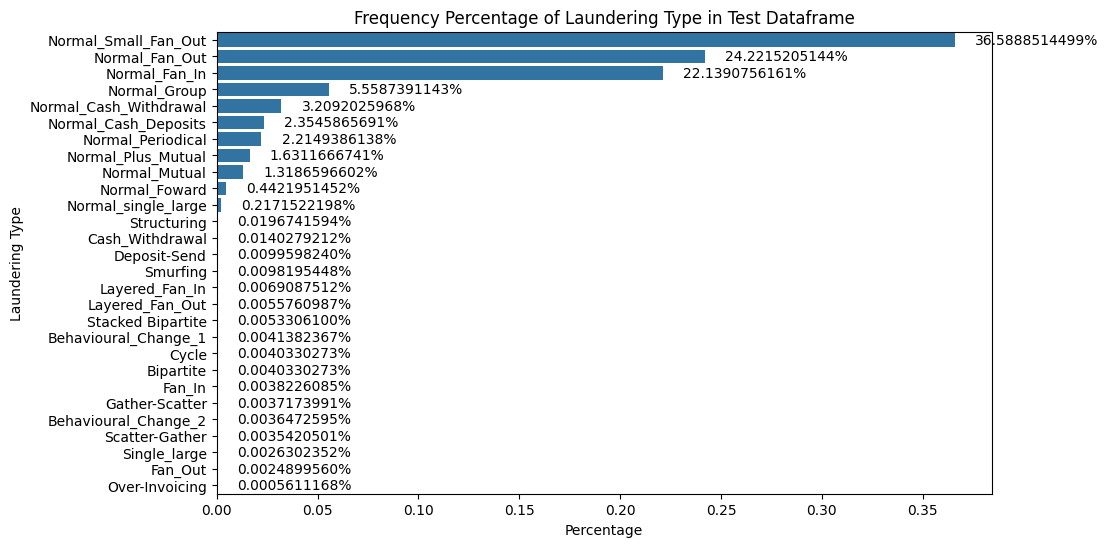

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df is your DataFrame containing the 'Laundering_type' variable
# Check the distribution of 'Laundering_type'
distribution = train_df['Laundering_type'].value_counts(normalize=True)

# Create barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(y=distribution.index, x=distribution.values)

# Annotate bars with values
for i, v in enumerate(distribution.values):
    ax.text(v + 0.01, i, '{:.10f}%'.format(v*100), va='center')

# Set labels and title
plt.xlabel('Percentage')
plt.ylabel('Laundering Type')
plt.title('Frequency Percentage of Laundering Type in Train Dataframe')

# Show plot
plt.show()



import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df is your DataFrame containing the 'Laundering_type' variable
# Check the distribution of 'Laundering_type'
distribution = test_df['Laundering_type'].value_counts(normalize=True)

# Create barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(y=distribution.index, x=distribution.values)

# Annotate bars with values
for i, v in enumerate(distribution.values):
    ax.text(v + 0.01, i, '{:.10f}%'.format(v*100), va='center')

# Set labels and title
plt.xlabel('Percentage')
plt.ylabel('Laundering Type')
plt.title('Frequency Percentage of Laundering Type in Test Dataframe')

# Show plot
plt.show()

In [35]:
# save train_df and test_df
train_df.to_feather("train_df.feather")
test_df.to_feather("test.feather")
del train_df, test_df

In [36]:
# Load DataFrame from the feather file
train_df = pd.read_feather('train_df.feather')
test_df = pd.read_feather('test.feather')

In [37]:
# Check if ok or not
train_df.head()

,Transaction_id,Sender_account,Receiver_account,Sender_bank_location,Receiver_bank_location,Payment_type,Last_transaction_time_elapsed_minutes,Amount_USD,Sender_bank_location_risk,Receiver_bank_location_risk,Payment_type_risk,Different_Currency,sender_f_degree_in,sender_f_degree_out,sender_f_amount_in,sender_f_amount_out,sender_f_nr_trans_in,sender_f_nr_trans_out,sender_f_average_amount_in,sender_f_average_amount_out,sender_f_ego_edge_density,sender_f_egored_degree_in,sender_f_egored_degree_out,sender_f_egored_amount_in,sender_f_egored_amount_out,sender_f_egored_nr_trans_in,sender_f_egored_nr_trans_out,sender_f_egored_average_amount_in,sender_f_egored_average_amount_out,sender_f_egored_edge_density,sender_f_egored_degree_in_rel,sender_f_egored_degree_out_rel,sender_f_egored_amount_in_rel,sender_f_egored_amount_out_rel,sender_f_egored_average_amount_in_rel,sender_f_egored_average_amount_out_rel,sender_max_cycle_length,sender_cycle_total_amount_USD,receiver_f_degree_in,receiver_f_degree_out,receiver_f_amount_in,receiver_f_amount_out,receiver_f_nr_trans_in,receiver_f_nr_trans_out,receiver_f_average_amount_in,receiver_f_average_amount_out,receiver_f_ego_edge_density,receiver_f_egored_degree_in,receiver_f_egored_degree_out,receiver_f_egored_amount_in,receiver_f_egored_amount_out,receiver_f_egored_nr_trans_in,receiver_f_egored_nr_trans_out,receiver_f_egored_average_amount_in,receiver_f_egored_average_amount_out,receiver_f_egored_edge_density,receiver_f_egored_degree_in_rel,receiver_f_egored_degree_out_rel,receiver_f_egored_amount_in_rel,receiver_f_egored_amount_out_rel,receiver_f_egored_average_amount_in_rel,receiver_f_egored_average_amount_out_rel,receiver_max_cycle_length,receiver_cycle_total_amount_USD,Is_laundering,Laundering_type
5390771,T6977154,3925886128,4465759925,USA,UK,Cross-border,245.816667,6808.720000,4,4,7,1,16,42,3.053331e+06,3.876100e+06,189,521,16155.193014,7439.731797,1.000000,1,1,84157.731216,105564.55572,4,5,21039.432804,21112.911144,1.0,0.0625,0.02381,0.027563,0.027235,1.302332,2.837859,2,189722.286936,1,0,8.082458e+04,0.000000e+00,12,0,6735.381667,0.000000,0.500000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,Normal_Periodical
7609415,T5909903,7198690908,1323360869,UK,UK,Debit card,0.000000,3719.166516,4,4,2,0,1,1,3.719167e+03,3.719167e+03,1,1,3719.166516,3719.166516,0.666667,0,0,0.000000,0.00000,0,0,0.000000,0.000000,0.0,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0,0.000000,1,0,3.719167e+03,0.000000e+00,1,0,3719.166516,0.000000,0.500000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,Normal_Foward
1926516,T8510862,3421266864,5679572583,France,UK,Cross-border,16.966667,13640.508488,4,4,7,1,0,1,0.000000e+00,1.648325e+05,0,12,0.000000,13736.038693,0.500000,0,0,0.000000,0.00000,0,0,0.000000,0.000000,0.0,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0,0.000000,19,3,3.020554e+06,4.823852e+05,220,7,13729.791678,68912.164353,1.000000,1,1,372308.999400,466169.637024,4,5,93077.249850,93233.927405,1.000000,0.052632,0.333333,0.123259,0.966385,6.779218,1.352939,2,838478.636424,0,Normal_Fan_In
1295051,T747042,4322968771,3565104110,UK,UK,Debit card,0.000000,13096.038852,4,4,2,0,0,1,0.000000e+00,1.567974e+05,0,12,0.000000,13066.451658,0.500000,0,0,0.000000,0.00000,0,0,0.000000,0.000000,0.0,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0,0.000000,19,47,2.382705e+06,4.390533e+06,203,534,11737.463750,8221.972017,1.015385,2,2,228112.122888,558217.097100,7,4,32587.446127,139554.274275,1.333333,0.105263,0.042553,0.095737,0.127141,2.776362,16.973334,2,677182.168728,0,Normal_Fan_In
1454362,T2660645,8262348471,5905719008,UK,UK,Debit card,168.400000,30121.936884,4,4,2,0,0,1,0.000000e+00,3.633101e+05,0,12,0.000000,30275.843364,0.500000,0,0,0.000000,0.00000,0,0,0.000000,0.000000,0.0,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0,0.000000,13,22,2.380331e+06,2.233474e+06

In [38]:
# Check if ok or not
test_df.head()

,Transaction_id,Sender_account,Receiver_account,Sender_bank_location,Receiver_bank_location,Payment_type,Last_transaction_time_elapsed_minutes,Amount_USD,Sender_bank_location_risk,Receiver_bank_location_risk,Payment_type_risk,Different_Currency,sender_f_degree_in,sender_f_degree_out,sender_f_amount_in,sender_f_amount_out,sender_f_nr_trans_in,sender_f_nr_trans_out,sender_f_average_amount_in,sender_f_average_amount_out,sender_f_ego_edge_density,sender_f_egored_degree_in,sender_f_egored_degree_out,sender_f_egored_amount_in,sender_f_egored_amount_out,sender_f_egored_nr_trans_in,sender_f_egored_nr_trans_out,sender_f_egored_average_amount_in,sender_f_egored_average_amount_out,sender_f_egored_edge_density,sender_f_egored_degree_in_rel,sender_f_egored_degree_out_rel,sender_f_egored_amount_in_rel,sender_f_egored_amount_out_rel,sender_f_egored_average_amount_in_rel,sender_f_egored_average_amount_out_rel,sender_max_cycle_length,sender_cycle_total_amount_USD,receiver_f_degree_in,receiver_f_degree_out,receiver_f_amount_in,receiver_f_amount_out,receiver_f_nr_trans_in,receiver_f_nr_trans_out,receiver_f_average_amount_in,receiver_f_average_amount_out,receiver_f_ego_edge_density,receiver_f_egored_degree_in,receiver_f_egored_degree_out,receiver_f_egored_amount_in,receiver_f_egored_amount_out,receiver_f_egored_nr_trans_in,receiver_f_egored_nr_trans_out,receiver_f_egored_average_amount_in,receiver_f_egored_average_amount_out,receiver_f_egored_edge_density,receiver_f_egored_degree_in_rel,receiver_f_egored_degree_out_rel,receiver_f_egored_amount_in_rel,receiver_f_egored_amount_out_rel,receiver_f_egored_average_amount_in_rel,receiver_f_egored_average_amount_out_rel,receiver_max_cycle_length,receiver_cycle_total_amount_USD,Is_laundering,Laundering_type
7148520,T3141842,6494524357,4569596820,UK,Japan,Cross-border,1444.283333,3114.900360,4,5,7,1,23,42,3.482246e+06,4.098302e+06,251,509,13873.488156,8051.674233,1.000000,1,1,227286.120204,2.244067e+05,2,2,113643.060102,112203.339534,1.0,0.043478,0.023810,0.065270,0.054756,8.191383,13.935405,2,451692.799272,1,0,4.174667e+04,0.000000e+00,11,0,3795.151379,0.000000,0.500000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,Normal_Small_Fan_Out
6685759,T8696916,5808503989,7145880448,UK,UK,Cheque,3.833333,8313.135948,4,4,1,0,11,36,1.209581e+06,5.666479e+06,103,357,11743.501360,15872.491540,1.044444,3,3,320149.095084,1.036114e+06,11,6,29104.463189,172685.650410,1.5,0.272727,0.083333,0.264678,0.182850,2.478346,10.879555,2,362038.610232,1,0,1.089217e+05,0.000000e+00,13,0,8378.594316,0.000000,0.500000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,Normal_Fan_Out
9224422,T4904966,9588429566,7090392204,UK,UK,Debit card,4.950000,19384.293708,4,4,2,0,21,51,3.124345e+06,5.301327e+06,226,605,13824.535468,8762.523835,1.028571,3,3,284998.270244,8.852455e+05,12,6,23749.855854,147540.920202,1.5,0.142857,0.058824,0.091219,0.166986,1.717950,16.837720,2,161754.408972,1,0,2.528711e+05,0.000000e+00,13,0,19451.624148,0.000000,0.500000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,Normal_Fan_Out
958905,T9241807,3257148707,6473064432,UK,UK,Debit card,131.983333,13395.802680,4,4,2,0,0,1,0.000000e+00,1.617330e+05,0,12,0.000000,13477.749246,0.500000,0,0,0.000000,0.000000e+00,0,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,21,33,3.539821e+06,2.019653e+06,234,343,15127.441152,5888.201749,1.018868,2,2,65419.301376,324036.611028,6,2,10903.216896,162018.305514,1.333333,0.095238,0.060606,0.018481,0.160442,0.720758,27.515753,2,257756.406336,0,Normal_Fan_In
5118714,T8967262,3530045075,7713531280,UK,UK,Credit card,3444.483333,1407.827304,4,4,3,0,20,47,2.771527e+06,4.518334e+06,196,507,14140.444610,8911.900552,1.046875,4,4,489590.008128,6.779239e+05,9,7,54398.889792,96846.267869,1.6,0.20000